# Użycie wielomianów ortogonalnych do analizy EKG 

In [2]:
#=
using Polynomials
using SpecialPolynomials
using Plots
using LinearAlgebra
using CSV
using DataFrames
=#

## Wielomiany Ortogonalne

**Wielomiany ortogonalne** to rodzina wielomianów, w których iloczyn skalarny dwóch róznych wielomianów jest równa 0.

Jeżeli dodatkowo iloczyn skalarny wielomianu "przez siebie" jest równy 1, to nazywamy je **wielomianami ortonormalnymi**

Iloczyn skalarny wielomianów można zdefiniować jako:

$<P_m,P_n>=\int_a^b P_n(x)P_m(x)W(x)dx = 0$

Funkcja *W* jest nazywana *funkcją wagową*.

### Przykładowe rodziny wielomianów ortogonalnych

| Nazwa                | Przedział       | Funkcja wagowa           | Zastosowanie                                           | Parzystość                                                     |
|----------------------|-----------------|--------------------------|--------------------------------------------------------|----------------------------------------------------------------|
| Czebyszewa (1 rzędu) | [-1,1]          | $\frac{1}{\sqrt{1-x^2}}$ | Zera wielomianu jako węzły interpolacji wielomianowej  | Dla parzystego k - parzyste, dla nieparzystego k - nieparzyste |
| Legendre             | [-1,1]          | 1                        | Zera wielomianu jako węzły kwadratur Gaussa-Legendre'a | jw                                                             |
| Hermite              | [$-\infty$,$\infty$] | $\exp(-x^2)$             | Zera wielomianu jako węzły kwadratur Gaussa-Hermite'a  | jw                                                             |
| Laguerre             | [0,$\infty$]      | $\exp(-x)$               | Zera wielomianu jako węzły kwadratur Gaussa-Laguerra'a | brak                                                           |


### Wielomiany Hermite'a

Zdefiniowane są rekurencyjnie jako:

$H_0(x) = 1$

$H_1(x) = 2x$

$H_{n+1}(x) = 2xH_n(x)-2nH_{n-1}$

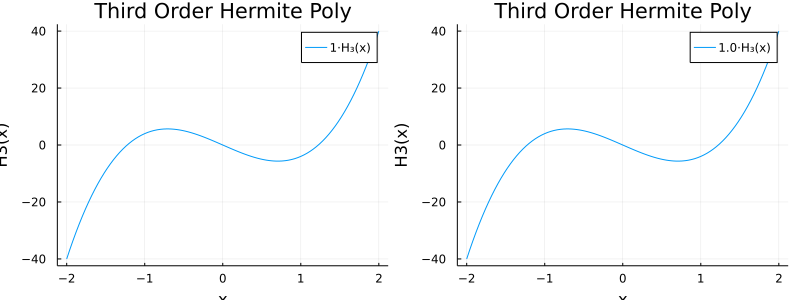

In [187]:
# Example of 3-rd degree Hermite Poly plot
h3 = Hermite([0, 0, 0, 1])
ph3 = plot(h3, -2, 2)
h4 = basis(Hermite, 3)
ph4 = plot(h4, -2, 2)
plot(ph3, ph4, size=(800,300), title="Third Order Hermite Poly", xaxis="x", yaxis="H3(x)")

### Przykład aproksymacji

Spróbujemy dokonać aproksymacji zaszumionej funkcji `cos` wykorzystując rodzinę wielomianów ortogonalnych Hermite'a.

Obliczony wektor wartości normalizujemy do 1, żeby łatwiej policzyć współczynniki aproksymacji (niżej objaśnienie dlaczego łatwiej). 

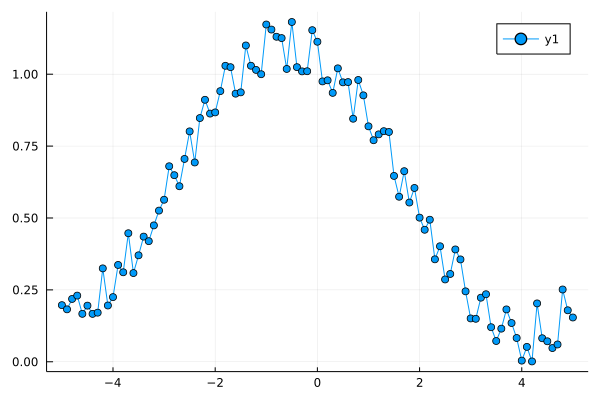

In [215]:
# Nodes def, Plot
xx = -5:.1:5
yy = cos.(xx/3 .+.2).^2 .+ rand(length(xx))/5
plot(xx, yy, markershape=:circle)

In [12]:
#przykład prostego wektora, który znormalizujemy
vec=[2,2,2,2]

4-element Vector{Int64}:
 2
 2
 2
 2

In [8]:
# iloczyn skalarny = długość^2
dot(vec,vec)

16

In [9]:
# normalizacja - długość wektora =1
normalize(vec)

4-element Vector{Float64}:
 0.5
 0.5
 0.5
 0.5

In [13]:
# sprawdzamy długość^2
dot(normalize(vec), normalize(vec))

1.0

* 0bliczamy funkcję bazową uwzględniającą czynnik wagowy.
$<P_m,P_n>=\int_{-\infty}^{\infty} H_n(x)H_m(x)\exp(-x^2)dx 
= \int_{-\infty}^{\infty}\underbrace{H_n(x)\exp(-\frac{x^2}{2})}_{\text{funkcja bazowa}_n}\underbrace{H_m(x)\exp(-\frac{x^2}{2})}_{\text{funkcja bazowa}_m}$

* Wyliczamy jej wartości dla podanych punktów x
* Otrzymany wektor wartości normalizujemy


In [14]:
# obliczamy funkcję bazową
# argument 'norm'  na potrzeby wykresów
function base_fun(k, x, norm=true)
    H_k = basis(Hermite, k).(x)
    app = H_k .* exp.(-(x.^2)/2)
    # normalize to have norm 1
    if norm
        return normalize(app)
    end
    return app
end

base_fun (generic function with 2 methods)

In [85]:
y_2_unnorm = base_fun(2, xx, false);
y_2_norm = base_fun(2, xx);

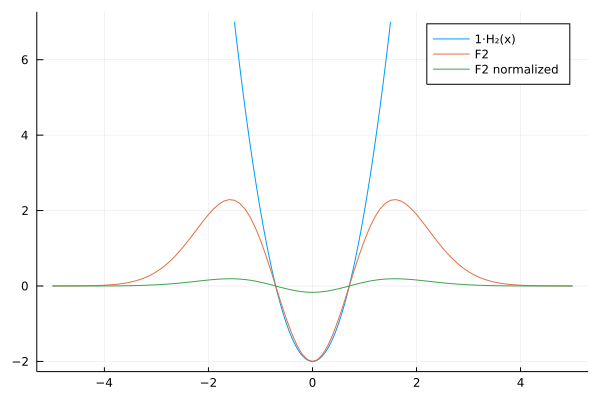

In [18]:
plot(Hermite([0, 0, 1]), -1.5, 1.5)
plot!(xx, y_2_unnorm, label="F2")
plot!(xx, y_2_norm, label="F2 normalized")

Obliczamy wektory wartosci dla punktów w xx dla kilku kolejnych funkcji bazowych

In [22]:
f0 = base_fun(0, xx, true);
f1 = base_fun(1, xx, true);
f2 = base_fun(2, xx, true);
f3 = base_fun(3, xx, true);

Sprawdźmy czy baza jest ortonormalna (uwaga: zamiast liczyć całkę, sprawdzamy po prostu iloczyn skalarny wektorów wartości)

In [23]:
dot_base = Array{Float64, 2}(undef, 4, 4); 

for (i, f_i) in enumerate([f0, f1, f2, f3]) 
    for (j, f_j) in enumerate([f0, f1, f2, f3])
        dot_base[i,j] = dot(f_i, f_j)
    end
end

In [31]:
dot_base

4×4 Matrix{Float64}:
  1.0          -3.46939e-19  -3.25356e-11  -1.8478e-18
 -3.46939e-19   1.0          -1.16044e-18  -9.61163e-10
 -3.25356e-11  -1.16044e-18   1.0          -8.92434e-18
 -1.8478e-18   -9.61163e-10  -8.92434e-18   1.0

OK, baza jest ortonormalna

Obliczamy kolejne współczynniki aproksymacji. Dzięki ortonormalnej bazie, poszczególne współczynniki są iloczynami skalarnymi wektora wartości funkcji aproksymowanej oraz  wektora bazowego (analogia: rzut  wektora wartości funkcji aproksymowanej w kierunku wektora bazowego).

Wektor bazowy jest znormalizowany $|\vec{j}|=1$, co upraszcza obliczenia.

Analogia w 2D

$\text{rzut }\vec{a} \text{ w kierunku }  \vec{j} =|\vec{a}|\cdot cos(\angle(\vec{a},\vec{j}))=|\vec{a}|\cdot|\vec{j}|\cdot cos(\angle(\vec{a},\vec{j}))=dot(\vec{a},\vec{j})$

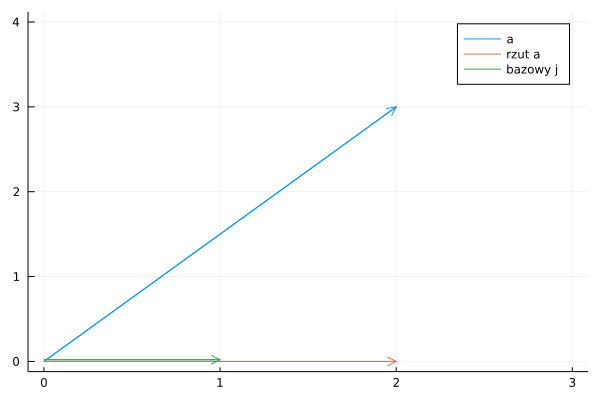

In [41]:
plot([0,2],[0,3],xrange=[0,3], yrange=[0,4],arrow=true, label="a")
plot!([0,2],[0,0],xrange=[0,3], yrange=[0,4],arrow=true, label="rzut a")
plot!([0,1],[0.02,0.02],xrange=[0,3], yrange=[0,4],arrow=true, label="bazowy j")

In [43]:
c0 = dot(yy, f0)
c1 = dot(yy, f1)
c2 = dot(yy, f2)
c3 = dot(yy, f3)
c0, c1, c2, c3

(5.7746137263239365, -0.9078652621127377, 2.720570660834042, -0.6848893708677646)

Liczymy wartości aproksymowane kolejnymi stopniami

In [44]:
y_app_0 = c0*f0;
y_app_1 = c1*f1;
y_app_2 = c2*f2;
y_app_3 = c3*f3;

101-element Vector{Float64}:
  8.225440657039577e-5
  0.0001266685066315461
  0.0001928487532168184
  0.0002902511723592204
  0.0004318252740296877
  0.0006350157356537949
  0.0009229238665498077
  0.001325597510818663
  0.0018813856234184748
  0.002638251888404035
  0.003654891332298227
  0.0050014376328577585
  0.006759491780120139
  ⋮
 -0.0050014376328577585
 -0.003654891332298227
 -0.002638251888404035
 -0.0018813856234184748
 -0.001325597510818663
 -0.0009229238665498077
 -0.0006350157356537949
 -0.0004318252740296877
 -0.0002902511723592204
 -0.0001928487532168184
 -0.0001266685066315461
 -8.225440657039577e-5

In [45]:
y_app_01 = y_app_0 + y_app_1;
y_app_012 = y_app_01 + y_app_2;
y_app_0123 = y_app_012 + y_app_3;

101-element Vector{Float64}:
 0.00017648813246567247
 0.00027554115003486823
 0.00042553905471293395
 0.0006500714648317136
 0.0009822850510066866
 0.0014680945261787669
 0.002170176595212021
 0.003172812370379072
 0.004587591779689144
 0.006559912752116382
 0.009276093997508492
 0.012970771009192429
 0.017934062533221613
 ⋮
 0.0017833986582084186
 0.0011478784684055272
 0.0007238863398912358
 0.00044633360520467363
 0.00026828252382291853
 0.00015654081632506358
 8.809670524424968e-5
 4.731617750463403e-5
 2.3797716610390266e-5
 1.0771367664618039e-5
 3.932824126347354e-6
 6.14359501647721e-7

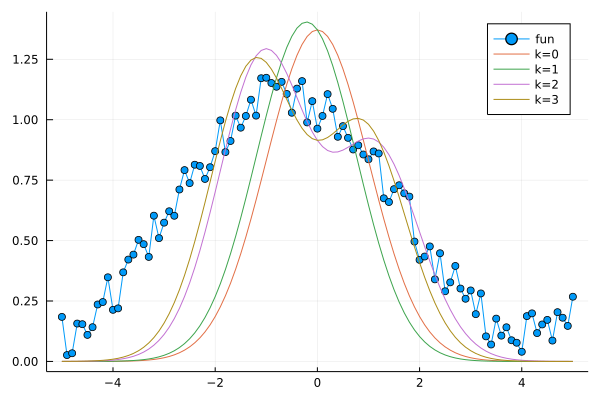

In [46]:
plot(xx, yy, markershape=:circle, label="fun")
plot!(xx, y_app_0, label="k=0")
plot!(xx, y_app_01, label="k=1")
plot!(xx, y_app_012, label="k=2")
plot!(xx, y_app_0123, label="k=3")

Liczymy błędy aproksymacji kolejnymi stopniami

In [47]:
using Statistics

In [48]:
mse(y1, y2) = mean((y1-y2).^2)

mse (generic function with 1 method)

In [49]:
mse(yy, y_app_0)

0.129364060338483

In [50]:
mse(yy, y_app_01)

0.12120347287164111

In [51]:
mse(yy, y_app_012)

0.04792124790517315

In [52]:
mse(yy, y_app_0123)

0.04327695630593633

### EKG

Dane pochodzą z bazy https://www.physionet.org/content/mitdb/1.0.0/ .

W sygnale można wyróżnić wiele struktur, z których najbardziej charakterystyczną jest zespół QRS.

In [53]:
ekg_data = CSV.read("ecg_data.csv", DataFrame);

In [54]:
first(ekg_data, 5)

,time,signalN,signalV
,Float64,Float64,Float64
1,-0.1,0.0183886,-0.0990972
2,-0.0972222,0.0145191,-0.0920442
3,-0.0944444,0.012849,-0.0831644
4,-0.0916667,0.0124946,-0.0722728
5,-0.0888889,0.0124117,-0.0593656


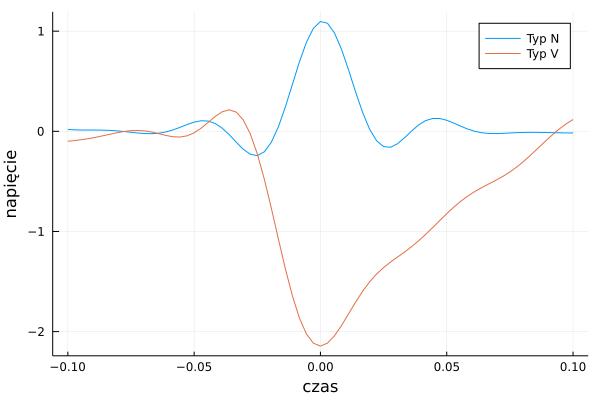

In [55]:
plot(ekg_data.time, ekg_data.signalN, label="Typ N", xlabel = "czas", ylabel="napięcie")
plot!(ekg_data.time, ekg_data.signalV, label="Typ V")

(5.725113911598116, -0.9157906158817669, 2.711325477169205, -0.8018390195854078)

Uwaga: Funkcje bazowe mają pewną "szerokość" i najlepiej aproksymują inne funkcje o podobnej szerokości. Można dodatkowo sparametryzować f. bazowe aby były węższe i lepiej pasowały do zespołów QRS. Na potrzeby laboratorium postąpimy inaczej - przeskalujemy oś X aproksymowanych sygnałów.

In [58]:
# Definicja węzłów
xx_ekg = ekg_data.time*40
yy_ekgV = ekg_data.signalV;

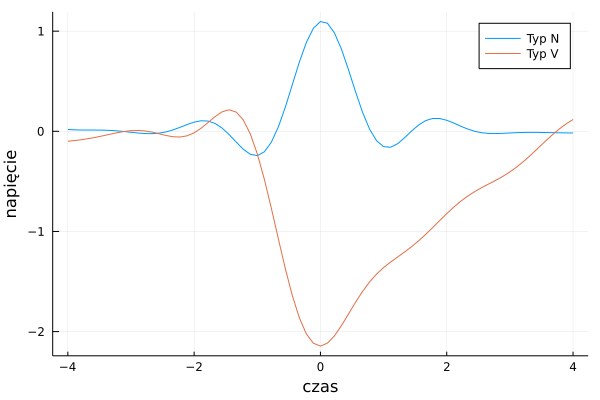

In [59]:
plot(xx_ekg, ekg_data.signalN, label="Typ N", xlabel = "czas", ylabel="napięcie")
plot!(xx_ekg, yy_ekgV, label="Typ V")

# Zadania

## Zadanie 1

Narysować 6 pierwszych wielomianów Hermita (na jednym wykresie albo siatce 2x3 lub 3x2)

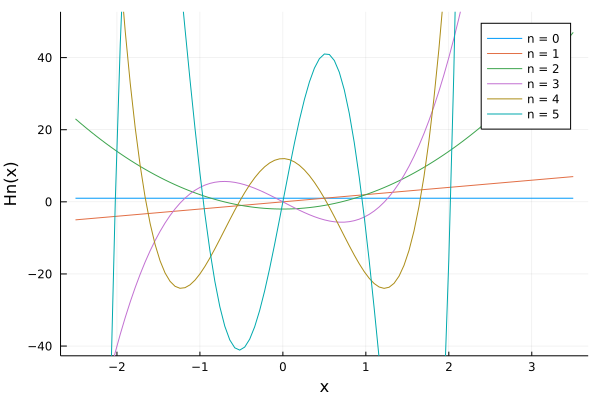

In [163]:
function plot_Hermite_polys(k)
    res = plot(basis(Hermite, 0), -2.5, 3.5, yrange=[-40, 50], xaxis="x", yaxis="Hn(x)", label=string("n = ", 0))
    for i in 1:k
        plot!(basis(Hermite, i), -2.5, 3.5, yrange=[-40, 50], label=string("n = ", i))
    end
    display(res)
end

plot_Hermite_polys(5)

## Zadanie 2

Narysować 6 pierwszych funkcji aproksymujących

In [216]:
# Function to approximate
xx = -5:.1:5
yy = cos.(xx/3 .+.2).^2 .+ rand(length(xx))/5;

- #### Określenie funkcji bazowych

In [449]:
function base_fun(k, x, norm=true)
    H_k = basis(Hermite, k).(x)
    app = H_k .* exp.(-(x.^2)/2)
    if norm
        return normalize(app)
    end
    return app
    end;

- #### Obliczenie wektorów wartości dla pierwszych 6 funkcji aproksymujących

In [332]:
function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    @eval (($s) = ($v))
    return v
end

function eval_base_vectors(N, xx)    
    
    res = Any[]
    
    for i in 0:N-1
        fun = base_fun(i, xx)
        push!(res, fun)
        # Metaprogramming kindergarten - evaluate function name with given string
        name = string("f", i)
        string_as_varname(name, fun)
    end
    return res
end

eval_base_vectors (generic function with 1 method)

In [339]:
res = eval_base_vectors(6, xx)

f0 == res[1] && f1 == res[2] && f2 == res[3] && f3 == res[4] && f4 == res[5] && f5 == res[6]

true

- #### Sprawdzamy, czy baza z poprzedniego punktu jest ortonormalna

<center>Zamiast liczyć całkę, sprawdzamy, czy zachodzą następujące 2 warunki:
</center>
<br>
<center>
1. Dla każdych dwóch różnych wektórów wartości ich iloczyn skalarny jest równy 0,
</center>
<center>
2. Iloczyn skalarny każdego wektora wartości z samym sobą wynosi 1.

In [385]:
dot_base = Array{Float64, 2}(undef, length(res), length(res))
accuracy = 1e-6
err = false

for (i, f_i) in enumerate(res) 
    for (j, f_j) in enumerate(res)
        dot_base[i,j] = dot(f_i, f_j)
        if abs(dot_base[i,j]) >= accuracy && i != j
            err = true
        end
        if i == j && abs(dot_base[i, j]) <= 0.99
            err = true
        end
    end
end
display(dot_base)
if !err
    print("\n\nAll good! Baza jest ortonormalna\n")
end

6×6 Matrix{Float64}:
  1.0          -3.46939e-19  -3.25356e-11  …  -4.52405e-10   2.2836e-18
 -3.46939e-19   1.0          -1.16044e-18     -5.28549e-19  -9.92118e-9
 -3.25356e-11  -1.16044e-18   1.0             -1.67261e-8    1.51788e-18
 -1.8478e-18   -9.61163e-10  -8.92434e-18      1.17636e-17  -2.04018e-7
 -4.52405e-10  -5.28549e-19  -1.67261e-8       1.0           2.38524e-17
  2.2836e-18   -9.92118e-9    1.51788e-18  …   2.38524e-17   1.0



All good! Baza jest ortonormalna


- #### Obliczamy współczynniki aproksymacji

Dzięki ortonormalnej bazie, poszczególne współczynniki są iloczynami skalarnymi wektora wartości funckji aproksymowanej oraz wektora bazowego (rzut wektora wartości funkcji aproksymującej w kierunku wektora bazowego).

In [387]:
c0 = dot(yy, f0)
c1 = dot(yy, f1)
c2 = dot(yy, f2)
c3 = dot(yy, f3)
c4 = dot(yy, f4)
c5 = dot(yy, f5)
c0, c1, c2, c3, c4, c5

(5.7670349712164946, -0.9114027433685999, 2.611210449200067, -0.6398743901551701, 1.4590437647281433, -0.68299722130332)

- #### Budujemy wielomiany aproksymujące kolejnych stopni z uwzględnieniem współczynnników aproksymacji


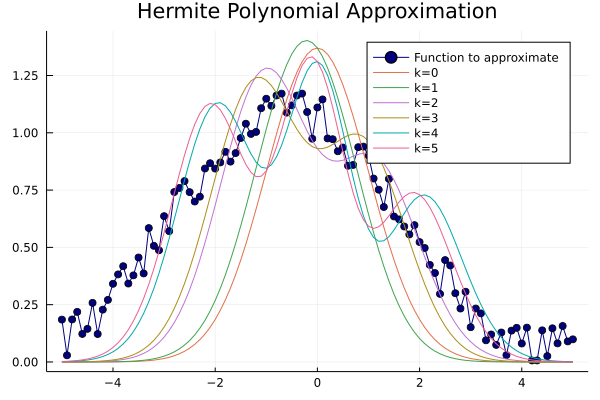

In [397]:
y_app_0 = c0*f0
y_app_1 = c1*f1
y_app_2 = c2*f2
y_app_3 = c3*f3
y_app_4 = c2*f4
y_app_5 = c3*f5

y_app_01 = y_app_0 + y_app_1
y_app_012 = y_app_01 + y_app_2
y_app_0123 = y_app_012 + y_app_3
y_app_01234 = y_app_0123 + y_app_4
y_app_012345 = y_app_01234 + y_app_5

plot(xx, yy, markershape=:circle, label="Function to approximate", color="navy", title="Hermite Polynomial Approximation")
plot!(xx, y_app_0, label="k=0")
plot!(xx, y_app_01, label="k=1")
plot!(xx, y_app_012, label="k=2")
plot!(xx, y_app_0123, label="k=3")
plot!(xx, y_app_01234, label="k=4")
plot!(xx, y_app_012345, label="k=5")

## Zadanie 3

Pokazać, że same wielomiany nie są ortogonalne, ale już z funkcją wagową $exp(-x^2)$ są. Uzyć metody z wektorami wartości, założyć pewien przedział.

In [559]:
# Define nodes
xxs = -5:.1:5

function base_fun_2(k, x, mult_by_weight=false)
    H_k = basis(Hermite, k).(x)
    if mult_by_weight
        return H_k .* exp.(-(x.^2)/2)
    else
        return H_k
    end
end

# Get base vectors - either orthogonal or not
function eval_base_vectors(N, xx, mult_by_weight=false)
    funcs = Any[]
    for i in 0:N-1
        push!(funcs, base_fun_2(i, xx, mult_by_weight))
    end
    return funcs
end

eval_base_vectors (generic function with 2 methods)

- Tworzymy przykładowe N wektorów dla punktów xx - reprezentujących wartości wielomianów Hermite'a w punktach xx

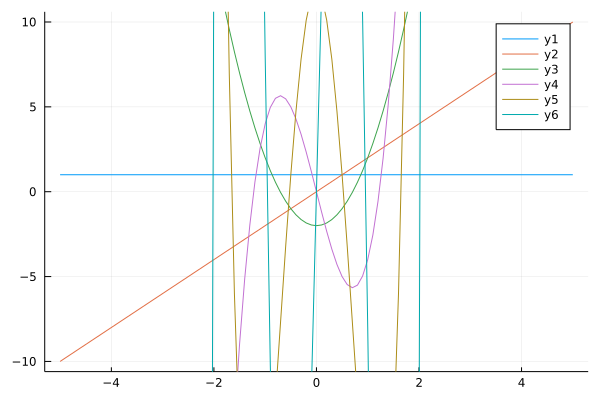

In [560]:
# Let N = 6
funcs = eval_base_vectors(6, xxs)

function plot_polys(xx, funcs)
    p = Any
    for i in 0:length(funcs)-1
        if i == 0
            p = plot(xx, funcs[i+1], yrange=[-10, 10])
        else
            p = plot!(xx, funcs[i+1])
        end
    end
    display(p)
end

plot_polys(xxs, funcs)

- Ustalamy, czy ta baza jest ortogonalna poprzez sprawdzenie, czy dla każdych dwóch różnych wektórów wartości ich iloczyn skalarny jest równy 0

In [566]:
function check_orthogonality(vectors, accuracy)
    err = false
    bad_dots = Any[]
    dot_base = Array{Float64, 2}(undef, length(vectors), length(vectors))
    for (i, f_i) in enumerate(vectors) 
        for (j, f_j) in enumerate(vectors)
            dot_base[i,j] = dot(f_i, f_j)
            if i != j && abs(dot_base[i,j]) > accuracy
                err = true
                push!(bad_dots, dot_base[i,j])
            end
        end
    end
    display(dot_base)
    if !err
        print("\nAll good! With accuracy: ", accuracy, " Baza jest ortogonalna")
    else
        print("\nWith accuracy: ", accuracy, " Baza nie jest ortogonalna!\n\n")
        for i in 1:length(bad_dots)
            print(bad_dots[i], "\n")
        end
    end
    return !err
    end;

In [567]:
check_orthogonality(funcs, 1e-6)

6×6 Matrix{Float64}:
  101.0             5.32907e-15  …   1.70137e5    -1.45519e-11
    5.32907e-15  3434.0             -7.27596e-12   1.13091e7
 3232.0            -2.84217e-13      1.2485e7     -3.72529e-9
   -1.13687e-13     1.89529e5        2.32831e-9    8.52416e8
    1.70137e5      -7.27596e-12      8.80768e8    -1.78814e-7
   -1.45519e-11     1.13091e7    …  -1.78814e-7    6.01582e10


With accuracy: 1.0e-6 Baza nie jest ortogonalna!

3232.0
170137.32799999998
189529.328
1.13090850592e7
3232.0
1.24850450272e7
189529.328
8.524162881941248e8
170137.32799999998
1.24850450272e7
1.13090850592e7
8.524162881941248e8


false

- Przemnażamy wielomiany Hermite'a przez funkcję wagową, otrzymując tym samym wielomiany ortogonalne

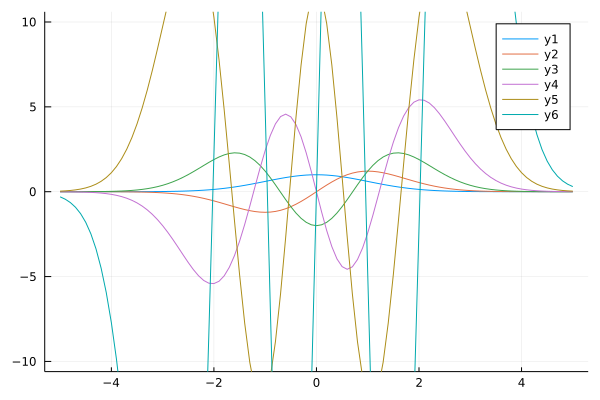

6×6 Matrix{Float64}:
 17.7245       -6.86723e-17  …    -1.57133e-7       2.89699e-15
 -6.86723e-17  35.4491            -2.0782e-15      -1.54106e-5
 -1.63109e-9    5.68772e-16       -1.64317e-5       1.11022e-16
  2.33754e-16  -1.6692e-7         -2.37588e-14     -0.0015525
 -1.57133e-7   -2.0782e-15      6806.22             7.81597e-14
  2.89699e-15  -1.54106e-5   …     7.81597e-14  68062.1

6×6 Matrix{Float64}:
 17.7245       -6.86723e-17  …    -1.57133e-7       2.89699e-15
 -6.86723e-17  35.4491            -2.0782e-15      -1.54106e-5
 -1.63109e-9    5.68772e-16       -1.64317e-5       1.11022e-16
  2.33754e-16  -1.6692e-7         -2.37588e-14     -0.0015525
 -1.57133e-7   -2.0782e-15      6806.22             7.81597e-14
  2.89699e-15  -1.54106e-5   …     7.81597e-14  68062.1


With accuracy: 1.0e-6 Baza nie jest ortogonalna!

-1.5410561227835462e-5
-1.643165241421718e-5
-0.0015524951153249589
-1.643165241421718e-5
-1.5410561227835462e-5
-0.0015524951153249589

All good! With accuracy: 0.01 Baza jest ortogonalna

In [568]:
ortho_vectors = eval_base_vectors(6, xxs, true)
plot_polys(xxs, ortho_vectors)
check_orthogonality(ortho_vectors, 1e-6)
check_orthogonality(ortho_vectors, 1e-2);

#### Zadanie 4  (1 pkt)

In [ ]:
H

Dokonać aproksymacji zespołu QRS typu N oraz V za pomocą kilku kolejnych stopni. Przedstawić osobno wykresy dla N i V.

#### Zadanie 5  (1 pkt)

Przedstawić wykres błędu aproksymacji w zależności od stopnia wielomianu dla stopni od 0 do 10. Jakiego stopnia należy użyć gdybyśmy mieli robić coś dalej z rezultatem aproksymacji?